In [1]:
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)
import numpy as np
import tensorflow as tf
from zipfile import ZipFile
from PIL import Image,ImageOps
import tqdm
import glob

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [2]:
########################################################################################################################
'''Global Variables'''
########################################################################################################################

LABELS=['Neutral','Happy','Sad','Surprise','Fear','Disgust','Anger','Contempt']
LABELS_MAP={str(key):lable for key,lable in zip(range(len(LABELS)),LABELS)}
NUM_CLASSES = len(LABELS)

ZIP_FILE_NAME = "J:/Emotion/AffectNet.zip"
RECORD_RIR="AffectNetRecords_64x64_gray/"

ANNOTATION_SUFFIX_KEYS=['aro','val','exp']
ANNOTATION_TYPES={'aro':'float','val' :'float','exp':'int'}
DATA_DICT_KEYS=['image','expression','arousal','valence']

ANNOTATION_MAP={annotation:key  for annotation in ANNOTATION_SUFFIX_KEYS for key in DATA_DICT_KEYS if annotation in key}

IMAGE_SIZE=64
COLORS=['RGB','GRAY']
COLOR=COLORS[1]


In [3]:
LABELS_MAP

{'0': 'Neutral',
 '1': 'Happy',
 '2': 'Sad',
 '3': 'Surprise',
 '4': 'Fear',
 '5': 'Disgust',
 '6': 'Anger',
 '7': 'Contempt'}

In [4]:
def count_data(file_name=ZIP_FILE_NAME):
    
    with ZipFile(file_name,'r') as zip_archive:
        files = zip_archive.namelist()
        

    return int(len(files)/5)

In [5]:
count_data()

287651

In [6]:
def load_annotation_from_zipFile(file_name=ZIP_FILE_NAME,annotation_Suffix=ANNOTATION_SUFFIX_KEYS):
    annotations={key:[] for key in annotation_Suffix}
    with ZipFile(file_name,'r') as zip_archive:
        for file in zip_archive.namelist():
            paths = file.split(sep='/')
            if paths[1] == 'annotations':
                annotation_suffix = paths[-1].split('_')[-1].split('.')[0]
                if annotation_suffix in annotation_Suffix:
                    annotations[annotation_suffix].append(np.load(zip_archive.open(file)))
    return annotations


In [7]:
annotations = load_annotation_from_zipFile()

In [11]:
np.array(annotations['exp'][0]).item()

'1'

In [12]:
expressions_count ={}
for expression in annotations['exp']:
    exp = np.array(expression).item()
    try: 
        expressions_count[exp]+=1
    except:
        expressions_count[exp]=1

In [13]:
expressions_count


{'1': 134415,
 '0': 74874,
 '6': 24882,
 '3': 14090,
 '4': 6378,
 '7': 3750,
 '2': 25459,
 '5': 3803}

In [14]:
expression_labels={}
for index,label in enumerate(LABELS):
    try:
        count = expressions_count[str(index)]
        expression_labels[ label]=count
    except:
        print('lable -{}- does not exist '.format(label))
expression_labels

{'Neutral': 74874,
 'Happy': 134415,
 'Sad': 25459,
 'Surprise': 14090,
 'Fear': 6378,
 'Disgust': 3803,
 'Anger': 24882,
 'Contempt': 3750}

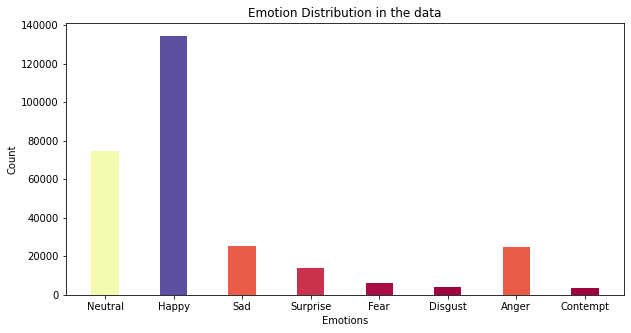

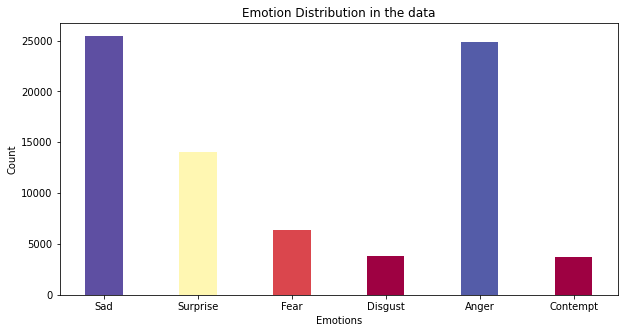

In [15]:
Labels = list(expression_labels.keys())
values = list(expression_labels.values())
norm = Normalize(vmin=min(values), vmax=max(values))
Barcmap = cm.get_cmap('Spectral')(norm(values))

fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(Labels, values,color =Barcmap,
        width = 0.4)
 
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.title("Emotion Distribution in the data")
plt.show()

  

Labels = list(expression_labels.keys())[2:]
values = list(expression_labels.values())[2:]

norm = Normalize(vmin=min(values), vmax=max(values))
Barcmap = cm.get_cmap('Spectral')(norm(values))

fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(Labels, values,color =Barcmap,
        width = 0.4)
 
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.title("Emotion Distribution in the data")
plt.show()

In [16]:
arousals = np.array(annotations['aro'],dtype=float)
arousals

array([-0.0555556, -0.137627 ,  0.0919473, ...,  0.400337 ,  0.609756 ,
        0.283921 ])

In [17]:
np.max(arousals),np.min(arousals)

(0.996903, -0.971666)

In [18]:
valence = np.array(annotations['val'],dtype=float)
valence

array([ 0.785714,  0.784476,  0.774293, ..., -0.695322,  0.406504,
        0.762104])

In [19]:
np.max(valence),np.min(valence)

(0.999081, -0.999081)

In [20]:
freq,val = np.histogram(valence,20)
np.diff(val),val

(array([0.0999081, 0.0999081, 0.0999081, 0.0999081, 0.0999081, 0.0999081,
        0.0999081, 0.0999081, 0.0999081, 0.0999081, 0.0999081, 0.0999081,
        0.0999081, 0.0999081, 0.0999081, 0.0999081, 0.0999081, 0.0999081,
        0.0999081, 0.0999081]),
 array([-0.999081 , -0.8991729, -0.7992648, -0.6993567, -0.5994486,
        -0.4995405, -0.3996324, -0.2997243, -0.1998162, -0.0999081,
         0.       ,  0.0999081,  0.1998162,  0.2997243,  0.3996324,
         0.4995405,  0.5994486,  0.6993567,  0.7992648,  0.8991729,
         0.999081 ]))

In [21]:
def plot_histogram(histogram,x_label,y_label,tilte):
    #bins = np.arange(n_bins)
    frq, val = histogram
    fig, ax = plt.subplots()
    ax.bar(val[:-1], frq, width=np.diff(val), edgecolor="black", align="edge")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(tilte)
    plt.show()


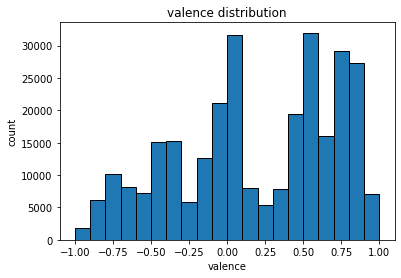

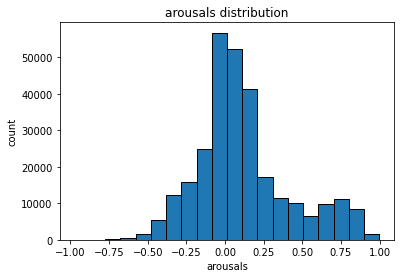

In [22]:
plot_histogram(np.histogram(valence,20),'valence','count','valence distribution')
plot_histogram(np.histogram(arousals,20),'arousals','count','arousals distribution')

In [23]:
expressions_valence = {LABELS_MAP[e]:[] for e in list(expressions_count.keys())}
expressions_arousal = {LABELS_MAP[e]:[] for e in list(expressions_count.keys())}
expressions_valence

{'Happy': [],
 'Neutral': [],
 'Anger': [],
 'Surprise': [],
 'Fear': [],
 'Contempt': [],
 'Sad': [],
 'Disgust': []}

In [24]:

for exp,val in zip(np.array(annotations['exp']),np.array(annotations['val'])):
    expressions_valence[LABELS_MAP[exp]].append(val)
for exp,aro in zip(np.array(annotations['exp']),np.array(annotations['aro'])):
    expressions_arousal[LABELS_MAP[exp]].append(aro)


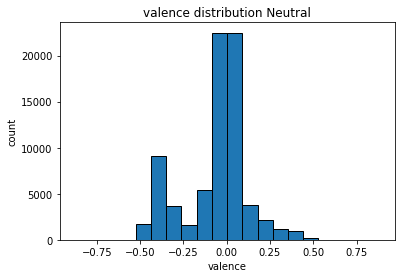

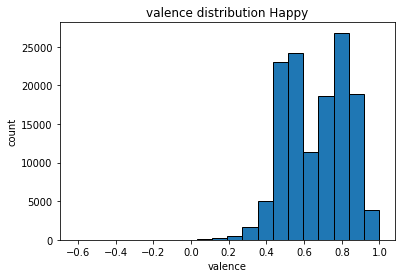

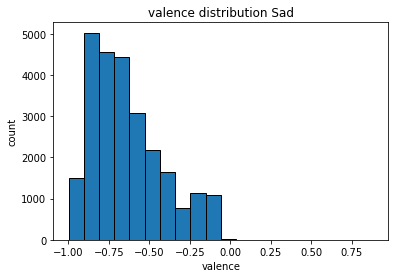

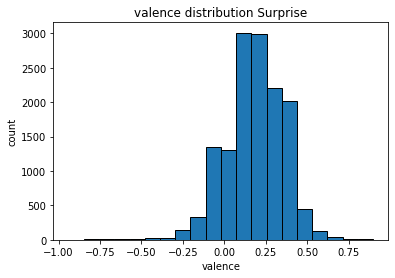

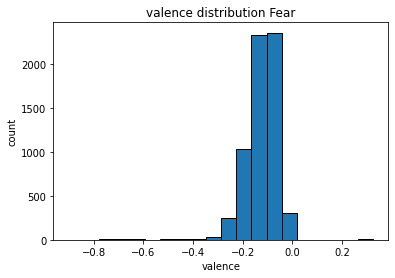

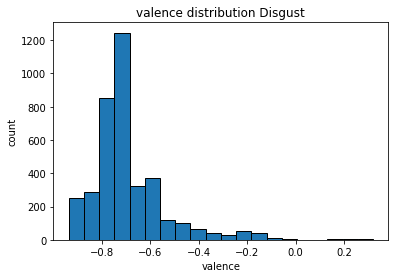

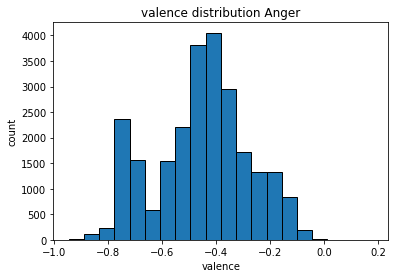

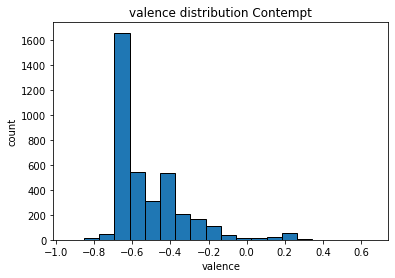

In [25]:
for label in LABELS:
    plot_histogram(np.histogram(np.array(expressions_valence[label],dtype=float),20),'valence','count','valence distribution '+label)


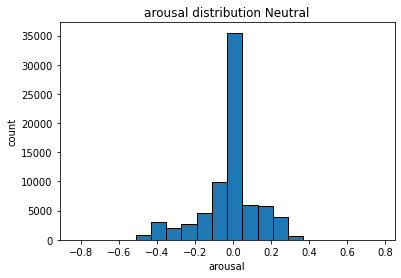

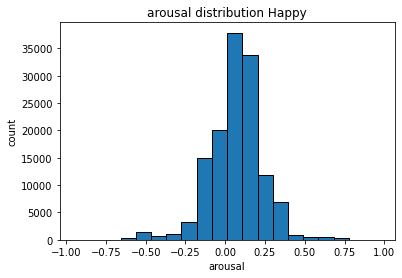

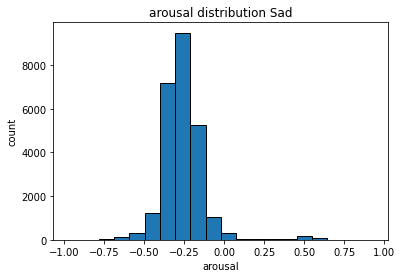

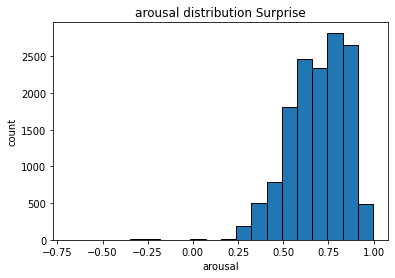

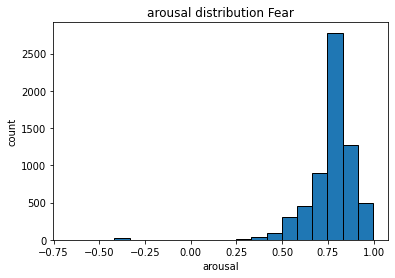

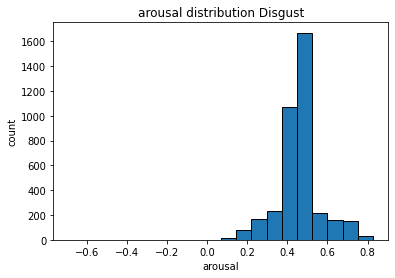

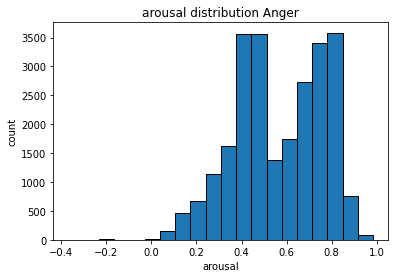

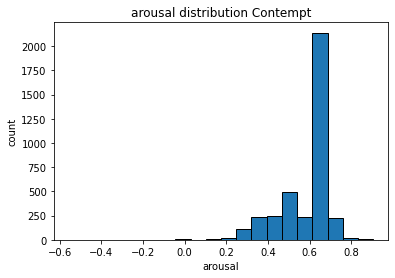

In [26]:
for label in LABELS:
    plot_histogram(np.histogram(np.array(expressions_arousal[label],dtype=float),20),'arousal','count','arousal distribution '+label)


In [27]:
RESIZE=True

In [28]:
def load_data_point_from_zipFile_GEN(
    file_name=ZIP_FILE_NAME,
    data_dict_keys=DATA_DICT_KEYS,
    annotation_Suffix_keys=ANNOTATION_SUFFIX_KEYS,
    annotation_map=ANNOTATION_MAP,
    annotation_types=ANNOTATION_TYPES
):
    Data_point={key:None for key in data_dict_keys}
    Annotations = {key:None for key in annotation_Suffix_keys}
    with ZipFile(file_name,'r') as zip_archive:
        for file in zip_archive.namelist():
            paths = file.split(sep='/')
            if paths[1] == 'annotations':
                annotation_suffix = paths[-1].split('_')[-1].split('.')[0]
                if annotation_suffix in annotation_Suffix_keys:
                    Annotations[annotation_suffix]=np.load(zip_archive.open(file))
                    Annotation_Loaded = not (None in Annotations.values())
                    if Annotation_Loaded:
                        for annotation_suffix in annotation_Suffix_keys:
                            Annotations[annotation_suffix]=np.array(Annotations[annotation_suffix],dtype=annotation_types[annotation_suffix])
                        image_path = paths[0]+'/images/'+paths[-1].split('_')[0]+'.jpg'
                        image_file = zip_archive.open(image_path)
                        image = Image.open(image_file)
                        if COLOR=='GRAY':
                            image = ImageOps.grayscale(image)
                        if RESIZE:
                            Data_point['image'] = np.array(image.resize((IMAGE_SIZE,IMAGE_SIZE)))
                        else:
                            Data_point['image'] = np.array(image)

                        for Annotation_key in annotation_Suffix_keys:
                            Data_point[annotation_map[Annotation_key]]=Annotations[Annotation_key]

                        yield Data_point
                        Data_point={key:None for key in data_dict_keys}
                        Annotations = {key:None for key in annotation_Suffix_keys}


In [29]:
data=next(load_data_point_from_zipFile_GEN())


In [30]:
data

{'image': array([[148, 135, 115, ..., 176, 173, 176],
        [135, 120, 100, ..., 177, 176, 178],
        [116,  96,  84, ..., 176, 177, 176],
        ...,
        [  8,  12,  96, ..., 131, 132, 131],
        [  8,  10,  73, ..., 132, 133, 132],
        [  9,   9,  46, ..., 131, 132, 131]], dtype=uint8),
 'expression': array(1),
 'arousal': array(-0.0555556),
 'valence': array(0.785714)}

In [31]:
expressions_count

{'1': 134415,
 '0': 74874,
 '6': 24882,
 '3': 14090,
 '4': 6378,
 '7': 3750,
 '2': 25459,
 '5': 3803}

In [ ]:
from zipfile import ZipFile
import os

def get_all_file_paths(directory):

    # initializing empty file paths list
    file_paths = []

    # crawling through directory and subdirectories
    for root, directories, files in os.walk(directory):
        for filename in files:
            # join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)

    # returning all file paths
    return file_paths

def main():
    # path to folder which needs to be zipped
    directory = './myfolder'

    # calling function to get all file paths in the directory
    file_paths = get_all_file_paths(directory)

    # printing the list of all files to be zipped
    print('Following files will be zipped in this program:')
    for file_name in file_paths:
        print(file_name)

        # writing files to a zipfile
        with ZipFile('myzipfile.zip','w') as zip:
            # writing each file one by one
            for file in file_paths:
                zip.write(file)

    print('All files zipped successfully!')





In [74]:
from tempfile import TemporaryFile
import os

ZIP_FILE_NAME_save = "J:/Emotion/AffectNetBalanced.zip"
temp_path = "J:/Emotion/AffectNetBalenced_Temp"
with ZipFile(ZIP_FILE_NAME_save,'w') as zip_archive:
    
    file_name= temp_path+'/1.npy'

    np.save(file_name, np.array(1))#
    file= np.load(file_name,allow_pickle=True)
    file_to_zip = open(file_name)
    zip_archive.write(file_to_zip,'/annotations/')
    
    
    
    

TypeError: stat: path should be string, bytes, os.PathLike or integer, not _io.TextIOWrapper

In [80]:
import os
import shutil
from zipfile import ZipFile
from os import path
from shutil import make_archive

# Check if file exists
if path.exists("J:/Emotion/AffectNetBalenced_Temp/1.npy"):
# get the path to the file in the current directory
    src = path.realpath("1.npy");
# rename the original file
    #os.rename("J:/Emotion/AffectNetBalenced_Temp/1.npy","J:/Emotion/AffectNetBalenced_Temp/2.npy")
# now put things into a ZIP archive
    root_dir,tail = path.split(src)
    shutil.make_archive("AffectNetBalenced_","zip",root_dir)
# more fine-grained control over ZIP files
    with ZipFile(ZIP_FILE_NAME_save, "w") as newzip:
        newzip.write("J:/Emotion/AffectNetBalenced_Temp/1.npy")


In [ ]:
max_value = max(expressions_count.values())
def balance_data(data_gen,expression_count):
    
    with ZipFile(file_name,'r') as zip_archive:
        
        data=next(load_data_point_from_zipFile_GEN())
        
